<span>
<b>Authors:</b> 
<a href="http://------">Ornela Danushi </a>
<a href="http://------">Gerlando Gramaglia </a>
<a href="http://------">Domenico Profumo </a><br/>
<b>Python version:</b>  3.x<br/>
</span>

# Data Understanding & Preparation on Tennis Matches dataset 
Explore the dataset by studying the data quality, their distribution among several different features and the correlations.

In [1]:
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sn
from scipy.stats.stats import pearsonr

Check the data integrity, that is whether there are any empty cells or corrupted data. For this purpose, use the Pandas function info(), which checks if there is any null value in any column. This function also checks data type for each column, as well as number of each data types and number of observations (rows).

In [2]:
df = pd.read_csv('dataset/matches_with_gender.csv', index_col = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186128 entries, 0 to 186127
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          186073 non-null  object 
 1   tourney_name        186103 non-null  object 
 2   surface             185940 non-null  object 
 3   draw_size           186099 non-null  float64
 4   tourney_level       186099 non-null  object 
 5   tourney_date        186100 non-null  float64
 6   match_num           186101 non-null  float64
 7   winner_id           186073 non-null  float64
 8   winner_entry        25827 non-null   object 
 9   winner_name         186101 non-null  object 
 10  winner_hand         186082 non-null  object 
 11  winner_ht           49341 non-null   float64
 12  winner_ioc          186099 non-null  object 
 13  winner_age          183275 non-null  float64
 14  loser_id            186100 non-null  float64
 15  loser_entry         44154 non-null

## Data Semantics
All attributes are spread in three macro categories: Tourney, Matches and Players; according to semantic meaning. Analyze each attribute type, conversion attribute's type, relationship, NaN and negative values.

### Tourney


#### draw_size

Number of players in the draw, often rounded up to the nearest power of 2. (For instance, a tournament with 28 players may be shown as 32).  
Since all powers of 2 are integers the idea is to convert to the 'int' format. Dafter converting them into integers, a logarithmic function is used to understand the right exponent that would allow to obtain the number with the nearest power of 2 for example 15-> 16 23-> 32 etc.

In [3]:
print("description of draw_size:" + "\n"+str(df.draw_size.describe()))
print("null_values: "+ str(df.draw_size.isnull().sum()))
print("unique value (before conversion):" + "\n"+str(df.draw_size.unique()))  
log= np.log2(df.draw_size)

for i in range(0, len(log)):
    dec, inter = math.modf(log[i])
    if dec == 0:
        log[i] = inter
    else:
        log[i] = inter + 1
df.draw_size = pow(2, log)
print("unique value (after conversion):" + "\n"+str(df.draw_size.unique()))  

description of draw_size:
count    186099.000000
mean         41.037276
std          25.349017
min           2.000000
25%          32.000000
50%          32.000000
75%          32.000000
max         128.000000
Name: draw_size, dtype: float64
null_values: 29
unique value (before conversion):
[ 32. 128.  64.   8.   4.  29.  16.  30.  31.  20.  28.  23.  25.  27.
  26.  19.  10.  15.  24.  18.  12.   2.  54.  48.  nan]
unique value (after conversion):
[ 32. 128.  64.   8.   4.  16.   2.  nan]


#### Drop Duplicates

In [4]:
df.drop_duplicates(inplace=True)
print("post drop duplicates length: ", len(df))

post drop duplicates length:  185819


#### tourney_id
Has to be unique and the first four characters are always the year while the remaining part is random.  
Split the value of the attribute in 2 parts, the first with 4 characters and the second with the remaining characters.
To detect the wrong ids is more difficult since they are random and don't follow a known a structure.
The only check that it's possible to do it's about first 4 characters that represent tourney year, if it's not correct then corresponding row is eliminated. In this case, no year of tourney_id is wrong, so no row is dropped. 

In [5]:
print("description of tourney_id:" + "\n"+str(df['tourney_id'].describe()))

print("null_values: "+ str(df['tourney_id'].isnull().sum())) #55
tourney_year= df['tourney_id'].str[:4]
tourney_id= df['tourney_id'].str[5:]

print("Present years: "+ str(tourney_year.unique())) #['2019' '2018' '2017' '2016' '2020' '2021' nan]


description of tourney_id:
count       185764
unique        4853
top       2021-520
freq           478
Name: tourney_id, dtype: object
null_values: 55
Present years: ['2019' '2018' '2017' '2016' '2020' '2021' nan]


#### tourney_name
is the name of the tourney.  
There are not many null values, the unique names turn out to be 2488, realize in total there are 2488 different tourneys but first is to be check the correctness of the names, that is made later on.

In [6]:
print("description of tourney_name:" + "\n"+str(df.tourney_name.describe()))
print("null_values: "+ str(df.tourney_name.isnull().sum()))

description of tourney_name:
count          185794
unique           2488
top       W15 Antalya
freq             4634
Name: tourney_name, dtype: object
null_values: 25


#### tourney_level

In [7]:
print("description of tourney_level:" + "\n"+str(df.tourney_level.describe()))
print("null_values: "+ str(df.tourney_level.isnull().sum()))
print("unique value:" + "\n"+str(df.tourney_level.unique())) 

description of tourney_level:
count     185790
unique        19
top           15
freq       45807
Name: tourney_level, dtype: object
null_values: 29
unique value:
['A' 'P' 'G' 'I' 'M' 'PM' 'F' 'D' 'C' '15' '25' '60' '100' '80' '10' '50'
 '75' 'O' 'W' nan]


#### tourney_spectators     tourney_revenue

In [8]:
print("\ndescription of:" + "\n"+str(df[['tourney_spectators', 'tourney_revenue']].describe()))
print("null_values:\t       "+ str(df.tourney_spectators.isnull().sum()) + "\t\t"
      + str(df.tourney_revenue.isnull().sum()))

df['tourney_spectators'] = round(df['tourney_spectators'], 0) 


description of:
       tourney_spectators  tourney_revenue
count       185792.000000     1.857930e+05
mean          4109.623466     8.228407e+05
std           2708.911943     6.012727e+05
min             91.000000     1.786574e+04
25%           2836.000000     5.473662e+05
50%           3340.000000     6.632303e+05
75%           4008.000000     8.342778e+05
max          18086.000000     5.002794e+06
null_values:	       27		26


### Matches

#### match_num

a match-specific identifier. Often starting from 1, sometimes counting down from 300, and sometimes arbitrary, there are few null values.

In [9]:
print("description of match_num:" + "\n"+str(df.match_num.describe()))
print("null_values: "+ str(df.match_num.isnull().sum()))

description of match_num:
count    185792.000000
mean        160.481038
std         289.544275
min           1.000000
25%          17.000000
50%         130.000000
75%         272.000000
max        8312.000000
Name: match_num, dtype: float64
null_values: 27


#### surface
kind of surface for the match. The surfaces are always of four types 'Hard' 'Clay' 'Grass' 'Carpet', there are 188 null values. With unique method verifies that there are no wrong values

In [10]:
print("description of surface:" + "\n"+str(df.surface.describe()))
print("null_values: "+ str(df.surface.isnull().sum()))
print("unique value:" + "\n"+str(df.surface.unique())) 

description of surface:
count     185631
unique         4
top         Hard
freq       94965
Name: surface, dtype: object
null_values: 188
unique value:
['Hard' 'Clay' 'Grass' 'Carpet' nan]


#### tourney_date
tourney_date: eight digits, YYYYMMDD, usually the Monday of the tournament week.
We convert type of tourney_date in Datetime64.

In [11]:
df.tourney_date.describe()
print("null_values: "+ str(df.tourney_date.isnull().sum())) #28

df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')

df.tourney_date.head()

null_values: 28


0   2018-12-31
1   2018-12-31
2   2018-12-31
3   2018-12-31
4   2018-12-31
Name: tourney_date, dtype: datetime64[ns]

#### minutes 

match length, where available.
The minutes are of type float, it is better to leave them in this format without further converting them to facilitate the statistical control of the data. From the description we can see the presence of many null values and the presence of some outliers to manage.

In [12]:
print("description of draw_size:" + "\n"+str(df.minutes.describe()))
print("null_values: "+ str(df.minutes.isnull().sum()))


description of draw_size:
count    81358.000000
mean        97.692593
std         41.514565
min          0.000000
25%         72.000000
50%         91.000000
75%        119.000000
max       4756.000000
Name: minutes, dtype: float64
null_values: 104461


#### score
Represents the score of each match
There are many unique values so it makes us think of many different scores between the various games, there are 193 Nan values. The score could be related to other attributes such as best_of

In [13]:
print("description of score:" + "\n"+str(df.score.describe()))
print("null_values: "+ str(df.score.isnull().sum()))

description of score:
count      185626
unique       9705
top       6-3 6-4
freq         5367
Name: score, dtype: object
null_values: 193


#### round


In [14]:
print("description of best_of:" + "\n"+str(df['round'].describe()))
print("null_values: "+ str(df['round'].isnull().sum()))
print("unique value:" + "\n"+str(df['round'].unique())) 

description of best_of:
count     185789
unique        12
top          R32
freq       63069
Name: round, dtype: object
null_values: 30
unique value:
['F' 'SF' 'QF' 'R16' 'R32' 'Q1' 'Q2' 'Q3' 'R64' 'R128' 'RR' 'BR' nan]


#### best_of
'3' or '5', indicating the maximum number of sets for this match
The values seem to enter the specified range because they are all 3-5 with the presence of some null values (29).

In [15]:
print("description of best_of:" + "\n"+str(df.best_of.describe()))
print("null_values: "+ str(df.best_of.isnull().sum())) 
print("unique value:" + "\n"+str(df.best_of.unique()))
b_of = df.groupby('best_of')['best_of'].count()
print("number of matches with best of 3 and 5",b_of)

description of best_of:
count    185790.000000
mean          3.034157
std           0.259128
min           3.000000
25%           3.000000
50%           3.000000
75%           3.000000
max           5.000000
Name: best_of, dtype: float64
null_values: 29
unique value:
[ 3.  5. nan]
number of matches with best of 3 and 5 best_of
3.0    182617
5.0      3173
Name: best_of, dtype: int64


### Players

#### winner_id and loser_id
the player_id used to identify a player among the matches.
Group each player's id with their name in order to have the player-id association in the player list. Through the groupby there isn't an univoque association between id-player and viceversa.

In [16]:
print("\ndescription of:" + "\n"+str(df[['winner_id', 'loser_id']].describe()))
print("null_values: \t  "+ str(df.winner_id.isnull().sum()) + "\t\t "
      + str(df.loser_id.isnull().sum())) 

print("verify the univoque association between winner_id and winner_name:\n",
      df.groupby(['winner_id']).winner_name.nunique().value_counts())
print("verify the univoque association between winner_name and winner_id:\n",
      df.groupby(['winner_name']).winner_id.nunique().value_counts())

print("verify the univoque association between loser_id and loser_name:\n",
      df.groupby(['loser_id']).loser_name.nunique().value_counts())
print("verify the univoque association between loser_name and loser_id:\n",
      df.groupby(['loser_name']).loser_id.nunique().value_counts())


description of:
           winner_id       loser_id
count  185764.000000  185791.000000
mean   180105.888068  181617.536258
std     46571.821798   46643.290091
min    100644.000000  100644.000000
25%    122330.000000  124079.000000
50%    203526.000000  205815.000000
75%    214152.000000  214818.000000
max    245099.000000  245099.000000
null_values: 	  55		 28
verify the univoque association between winner_id and winner_name:
 1    6163
2      13
Name: winner_name, dtype: int64
verify the univoque association between winner_name and winner_id:
 1    6171
2       9
Name: winner_id, dtype: int64
verify the univoque association between loser_id and loser_name:
 1    9983
2      48
Name: loser_name, dtype: int64
verify the univoque association between loser_name and loser_id:
 1    10041
2       19
Name: loser_id, dtype: int64


#### winner_name and loser_name
There are not so many null values

In [17]:
print("\ndescription of:" + "\n"+str(df[['winner_name', 'loser_name']].describe()))
print("null_values: \t    "+ str(df.winner_name.isnull().sum()) + "\t\t   "
      + str(df.loser_name.isnull().sum()))


description of:
           winner_name     loser_name
count           185792         185788
unique            6180          10060
top     Novak Djokovic  Federico Gaio
freq               289            180
null_values: 	    27		   31


#### Winner and loser ioc 
three-character country code associeted to a player. 
The nulls are few. A check made after is to verify if a player has more then one nationality associeced.

In [18]:
print("\ndescription of:" + "\n"+str(df[['winner_ioc', 'loser_ioc']].describe()))
print("null_values:    "+ str(df.winner_ioc.isnull().sum()) + "\t   "
      + str(df.loser_ioc.isnull().sum())) 

nation=np.concatenate((df.winner_ioc.unique(), df.loser_ioc.unique()),0)
country = pd.DataFrame(nation)
country = country.drop_duplicates()

print("\ndifferent county names:" + "\n" + str(country.describe()))


description of:
       winner_ioc loser_ioc
count      185790    185793
unique        124       154
top           USA       USA
freq        16394     16649
null_values:    29	   26

different county names:
          0
count   154
unique  154
top     JPN
freq      1


### winner and loser ht
height in centimetres, where available. There are a lot of null values, name and nationality could be used to resolve nan values.

In [19]:
print("\ndescription of:" + "\n"+str(df[['winner_ht', 'loser_ht']].describe()))
print("null_values:    "+ str(df.winner_ht.isnull().sum()) + "\t   "
      + str(df.loser_ht.isnull().sum()))


description of:
          winner_ht      loser_ht
count  49303.000000  38330.000000
mean     181.413768    181.566058
std       11.630702     10.816290
min        2.000000      2.000000
25%      175.000000    175.000000
50%      183.000000    183.000000
75%      188.000000    188.000000
max      211.000000    211.000000
null_values:    136516	   147489


#### winner and loser age
the age of the player, in years.  
Ages are transformed into integer values, also the age of the palyer can change according to the tournament so to find the corresponding player's age in Nan cells, is necessary to check both player's name and tourney_date.

In [20]:
print("\ndescription of:" + "\n"+str(df[['winner_age', 'loser_age']].describe()))
print("null_values:    "+ str(df.winner_age.isnull().sum()) + "\t   "
      + str(df.loser_age.isnull().sum()))
df['winner_age'],dec = divmod(df['winner_age'], 1)
df['loser_age'],dec = divmod(df['loser_age'], 1)


description of:
          winner_age      loser_age
count  182966.000000  179282.000000
mean       23.962916      23.765154
std         4.462881       4.630679
min        14.042437      14.006845
25%        20.490075      20.128679
50%        23.455168      23.225188
75%        26.869268      26.767967
max        95.000000      74.485969
null_values:    2853	   6537


#### winner_hand and loser_hand
R= right, L = left, U = unknown for ambidextrous players. This is their serving hand.
There are few nulls. Using unique method to verify if there are wrong values. In this case no wrong values are found.

In [21]:
print("\ndescription of:" + "\n"+str(df[['winner_hand', 'loser_hand']].describe()))
print("null_values:    "+ str(df.winner_hand.isnull().sum()) + "\t   "
      + str(df.loser_hand.isnull().sum()))
print("unique value winner_hand:" + "\n"+str(df.winner_hand.unique()))  
print("unique value loser_hand:" + "\n"+str(df.loser_hand.unique()))  



description of:
       winner_hand loser_hand
count       185773     185721
unique           3          3
top              R          R
freq        120395     109087
null_values:    46	   98
unique value winner_hand:
['R' 'L' 'U' nan]
unique value loser_hand:
['R' 'L' 'U' nan]


#### winner_entry and loser_entry
'WC' = wild card, 'Q' = qualifier, 'LL' = lucky loser, 'PR' = protected
ranking, 'ITF' = ITF entry, and there are a few others that are occasionally used.
There are many null values. The unique set of values is 18 values

In [22]:
df['winner_entry'] = df['winner_entry'].apply(lambda x: x.upper() if type(x)==str else x)
df['loser_entry'] = df['loser_entry'].apply(lambda x: x.upper() if type(x)==str else x)

print("\ndescription of:" + "\n"+str(df[['winner_entry', 'loser_entry']].describe()))
print("null_values:  "+ str(df.winner_entry.isnull().sum()) + "\t  "
      + str(df.loser_entry.isnull().sum()))
entry=np.concatenate((df.winner_entry.unique(), df.loser_entry.unique()),0)
entry = pd.DataFrame(entry)
entry = entry.drop_duplicates()
entry = entry.apply(lambda x: x.astype(str).str.upper())

print("\ndifferent entry:" + "\n" + str(entry.describe()))




description of:
       winner_entry loser_entry
count         25811       44088
unique           14          18
top               Q           Q
freq          13575       20346
null_values:  160008	  141731

different entry:
          0
count    19
unique   19
top     NAN
freq      1


#### winner_rank     loser_rank       
winner's ATP or WTA rank, as of the tourney_date, or the most recentranking date before the tourney_date. There are many Nan.

In [23]:
print("\ndescription of:" + "\n"+str(df[['winner_rank', 'loser_rank']].describe()))
print("null_values:   "+ str(df.winner_rank.isnull().sum()) + "\t      "
      + str(df.loser_rank.isnull().sum())) #19395 | 35235 



description of:
         winner_rank     loser_rank
count  166417.000000  150560.000000
mean      383.929562     434.280015
std       314.189123     355.959761
min         1.000000       1.000000
25%       137.000000     156.000000
50%       298.000000     325.000000
75%       562.000000     642.000000
max      2220.000000    2257.000000
null_values:   19402	      35259


#### winner_rank_points     loser_rank_points
Number of ranking points, where available.

In [24]:
print("\ndescription of:" + "\n"+str(df[['winner_rank_points', 'loser_rank_points']].describe()))
print("null_values:\t    "+ str(df.winner_rank_points.isnull().sum()) + "\t       "
      + str(df.loser_rank_points.isnull().sum())) #19413 | 35252 



description of:
       winner_rank_points  loser_rank_points
count       166399.000000      150543.000000
mean           470.938113         356.741157
std           1041.876111         703.211174
min              1.000000           1.000000
25%             49.000000          35.000000
50%            161.000000         138.000000
75%            439.000000         378.000000
max          16950.000000       16950.000000
null_values:	    19420	       35276


#### winner_gender  loser_gender
gender of winner and loser. Check if wrong values are present. No NaNs are present because unknown gender is marked with U.

In [25]:
print("\ndescription of:" + "\n"+str(df[['winner_gender', 'loser_gender']].describe()))
print("null_values: \t"+ str(df.winner_gender.isnull().sum()) + "\t     "
      + str(df.loser_gender.isnull().sum())) 

print("unique value:" + "\n"+str(df.winner_gender.unique())) 
print("unique value:" + "\n"+str(df.loser_gender.unique()))


description of:
       winner_gender loser_gender
count         185819       185819
unique             3            3
top                F            F
freq          125006       124979
null_values: 	0	     0
unique value:
['M' 'U' 'F']
unique value:
['M' 'U' 'F']


#### Description of remaining attributes 
Transform ace and double fault in integers and observe NaN values

In [26]:
def print_nan(df, s):
    print( s+" null_values:\t"+str(df[s].isnull().sum()))

In [27]:
df.w_ace =round(df.w_ace, 0) 
df.l_ace =round(df.l_ace, 0) 
df.w_df =round(df.w_df, 0) 
df.l_df =round(df.l_df, 0) 

df[['w_ace', 'l_ace', 'w_df', 'l_df', 'w_svpt', 'l_svpt', 'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon',
    'w_SvGms', 'l_SvGms', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced']].describe()

,w_ace,l_ace,w_df,l_df,w_svpt,l_svpt,w_1stIn,l_1stIn,w_1stWon,l_1stWon,w_SvGms,l_SvGms,w_bpSaved,l_bpSaved,w_bpFaced,l_bpFaced
count,82008.000000,82011.000000,82010.000000,82017.000000,82008.000000,82013.000000,82008.000000,82002.000000,82010.000000,82009.000000,82009.000000,82016.000000,82013.000000,82009.000000,82010.000000,82004.000000
mean,4.823249,3.535428,2.856310,3.609508,71.298032,73.571726,44.272522,44.565376,32.142787,28.045300,11.117377,10.942597,3.538719,4.658525,5.404548,8.864665
std,4.389550,3.831450,2.420703,2.606292,25.529907,24.992883,16.950519,16.777542,11.413477,12.273636,3.514158,3.499202,3.108314,3.147810,4.203817,3.967632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,2.000000,53.000000,56.000000,33.000000,33.000000,24.000000,19.000000,9.000000,9.000000,1.000000,2.000000,2.000000,6.000000
50%,4.000000,2.000000,2.000000,3.000000,67.000000,69.000000,42.000000,42.000000,30.000000,26.000000,10.000000,10.000000,3.000000,4.000000,5.000000,8.000000
75%,7.000000,5.000000,4.000000,5.000000,87.000000,88.000000,54.000000,54.000000,38.000000,35.000000,14.000000,13.000000,5.000000,6.000000,8.000000,11.000000
max,75.000000,67.000000,114.000000,114.000000,1957.000000,1672.000000,1330.000000,893.000000,836.000000,532.000000,49.000000,50.000000,209.000000,120.000000,266.000000,190.000000


In [28]:
print_nan(df, 'w_ace')
print_nan(df,'l_ace')
print_nan(df,'w_df')
print_nan(df,'l_df')
print_nan(df,'w_svpt')
print_nan(df,'l_svpt')
print_nan(df,'w_1stIn')
print_nan(df,'l_1stIn')
print_nan(df,'w_1stWon')
print_nan(df,'l_1stWon')
print_nan(df,'w_SvGms')
print_nan(df,'l_SvGms')
print_nan(df,'w_bpSaved')
print_nan(df,'l_bpSaved')
print_nan(df,'w_bpFaced')
print_nan(df,'l_bpFaced')

w_ace null_values:	103811
l_ace null_values:	103808
w_df null_values:	103809
l_df null_values:	103802
w_svpt null_values:	103811
l_svpt null_values:	103806
w_1stIn null_values:	103811
l_1stIn null_values:	103817
w_1stWon null_values:	103809
l_1stWon null_values:	103810
w_SvGms null_values:	103810
l_SvGms null_values:	103803
w_bpSaved null_values:	103806
l_bpSaved null_values:	103810
w_bpFaced null_values:	103809
l_bpFaced null_values:	103815


## Data Statistics and Data Distributions


### tourney_level with gender
tourney_level is an attribute that depends on the gender of the player, so their relations are highlighted.The majority of the matches have been played only between the same gender and so a consideration to be done is that of considering the 'U' value the same of the other member of the couple in which it appears; if the other value is 'M' and there is a 'U' then that 'U' has to be transformed in 'M', and vice versa. Considering also the fact that the tourney_level can be applied to that gender, otherwise also the known value has to be exchanged. By the graph can be seen the distribution of levels according the gender of the players, and so i.e. the 'C' between the man.

<AxesSubplot:title={'center':'Distribution of tourney_level values according to the gender of the player'}, xlabel='winner_gender,loser_gender'>

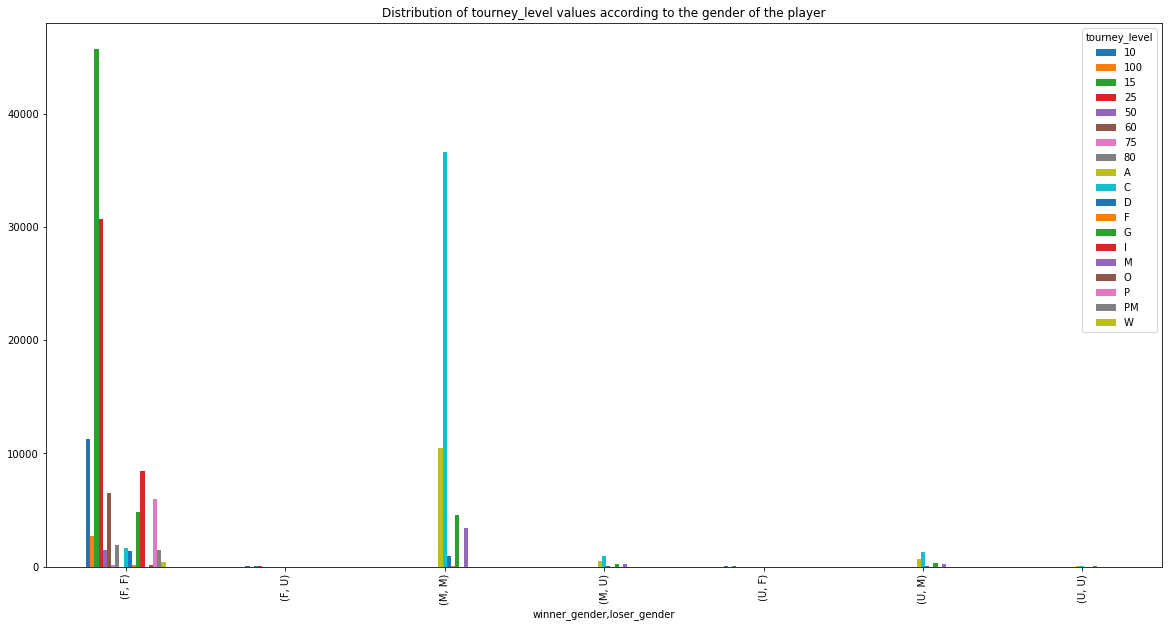

In [29]:
lf = df.groupby(['winner_gender', 'loser_gender', 'tourney_level']).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of tourney_level values according to the gender of the player", 
    kind='bar')

### tourney_spectators with tourney_revenue
Their distribution has a quite similar behaviour, following a linear trend.

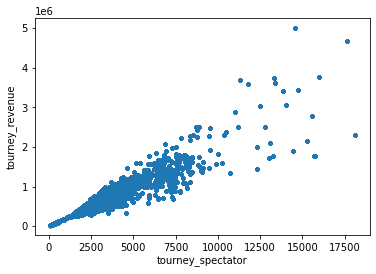

In [30]:
plt.xlabel('tourney_spectator')
plt.ylabel('tourney_revenue')
plt.scatter(df['tourney_spectators'], df['tourney_revenue'], s = 10)

### surface among years
Surface attribute has very few different values. To understand which type of surface has been used among the matches, it is put in relation with the years of the tourney_date values. Thanks to the visualization of their distribution we can conclude that they follow the same increasing way instead for the last year, denoted by 2021, there is an inversion of the 'Clay' with the 'Hard' surface type.


<AxesSubplot:title={'center':'Distribution of the surface values according to the years of the tourney_date values'}>

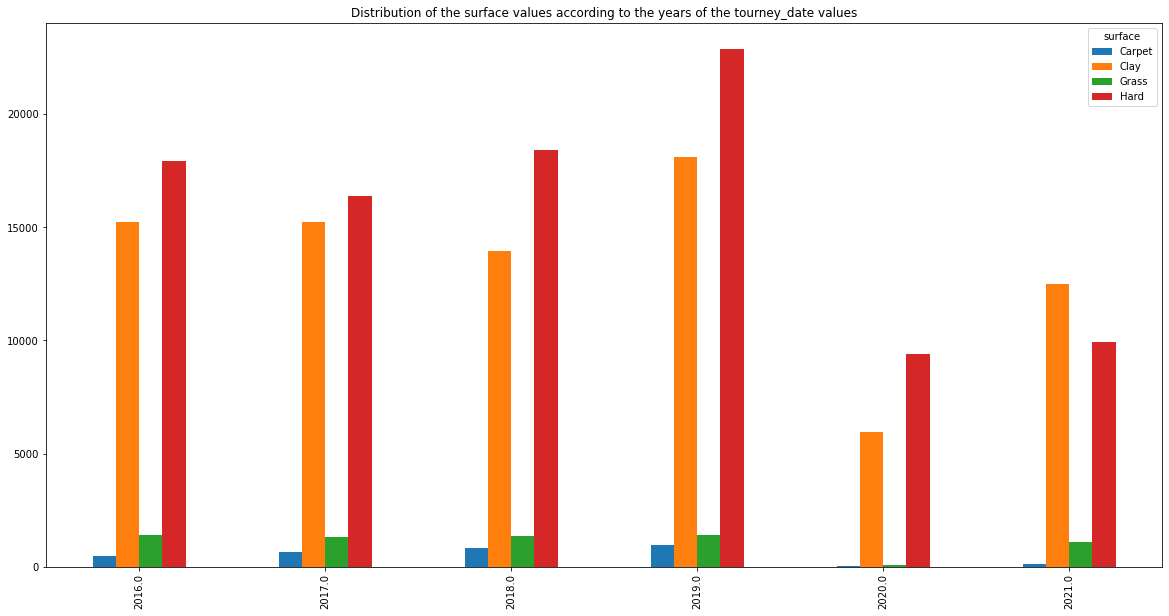

In [31]:
lf = df.groupby([ [x.year for x in df.tourney_date], 'surface']).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of the surface values according to the years of the tourney_date values", 
    kind='bar')

### matches among months
According to the distribution of the matches through the months and the years, they follow the same structure for the first 4 years, while in the last 2 there are no so much played matches due to Covid situation, in those years on July there are more matches played.

<AxesSubplot:title={'center':'Distribution of the matches according the months of the years'}>

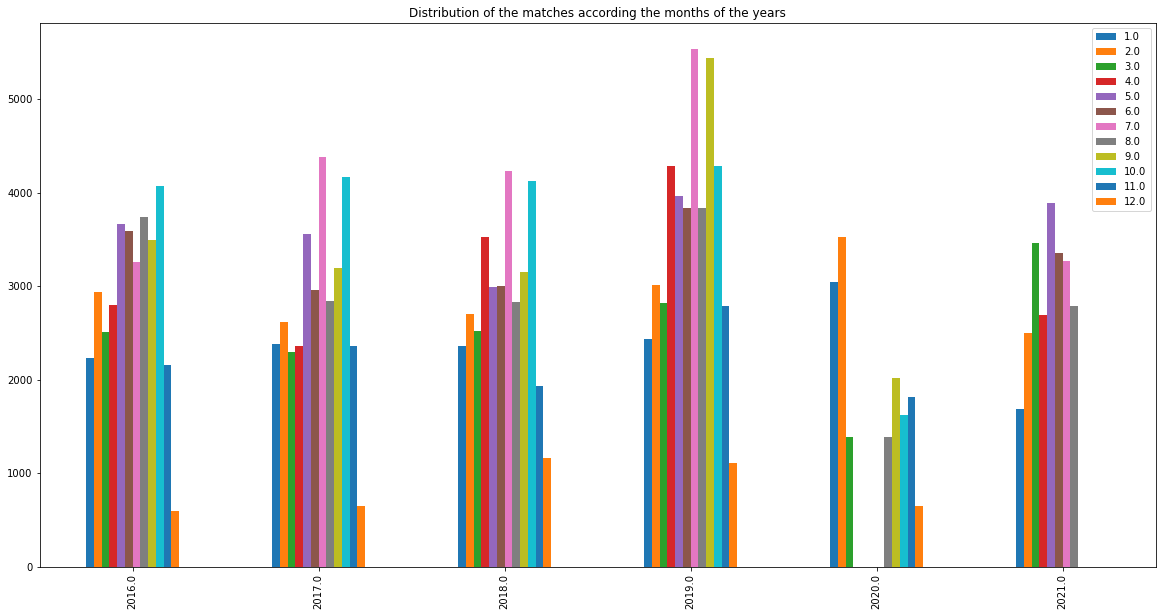

In [32]:
lf = df.groupby([ [x.year for x in df.tourney_date], [x.month for x in df.tourney_date]]).size()
lf = lf.unstack()
lf.plot(
    figsize=(20, 10), 
    title="Distribution of the matches according the months of the years", 
    kind='bar')

### Minutes
Transform minutes in hours and visualize the distribution of the matches duration, there are a lot of outliers.

{'whiskers': [<matplotlib.lines.Line2D at 0x1cfb1d18c40>,
 'caps': [<matplotlib.lines.Line2D at 0x1cfb1d262e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cfb1d187f0>],
 'medians': [<matplotlib.lines.Line2D at 0x1cfb1d26a00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cfb1d26d90>],
 'means': []}

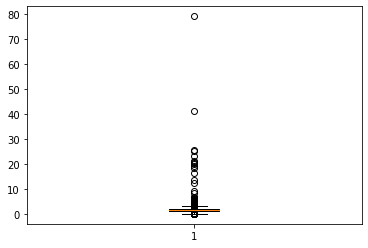

In [33]:
minutes = df['minutes']
minutes = pd.to_numeric(minutes, errors='coerce') #for removing all non-numeric values use to_numeric with parameter errors='coerce' - to replace non-numeric values to NaNs
minutes = minutes.dropna() #= minutes.fillna(-1)
minutes = minutes / 60
plt.boxplot(minutes)

### best_of
The majority of the best_of attribute is 3, it could be used to resolve missing values.

<BarContainer object of 2 artists>

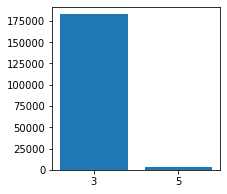

In [34]:
f, axs = plt.subplots(ncols=1, figsize=(3,3))
axs.bar(['3','5'],df.best_of.value_counts())

### nationality
Nationality distribution of winner and loser player on matches. The most prelevant nationality are USA, RUS, FRA and ITA.

<AxesSubplot:title={'center':'Distribution of winner_ioc'}, xlabel='winner_ioc'>

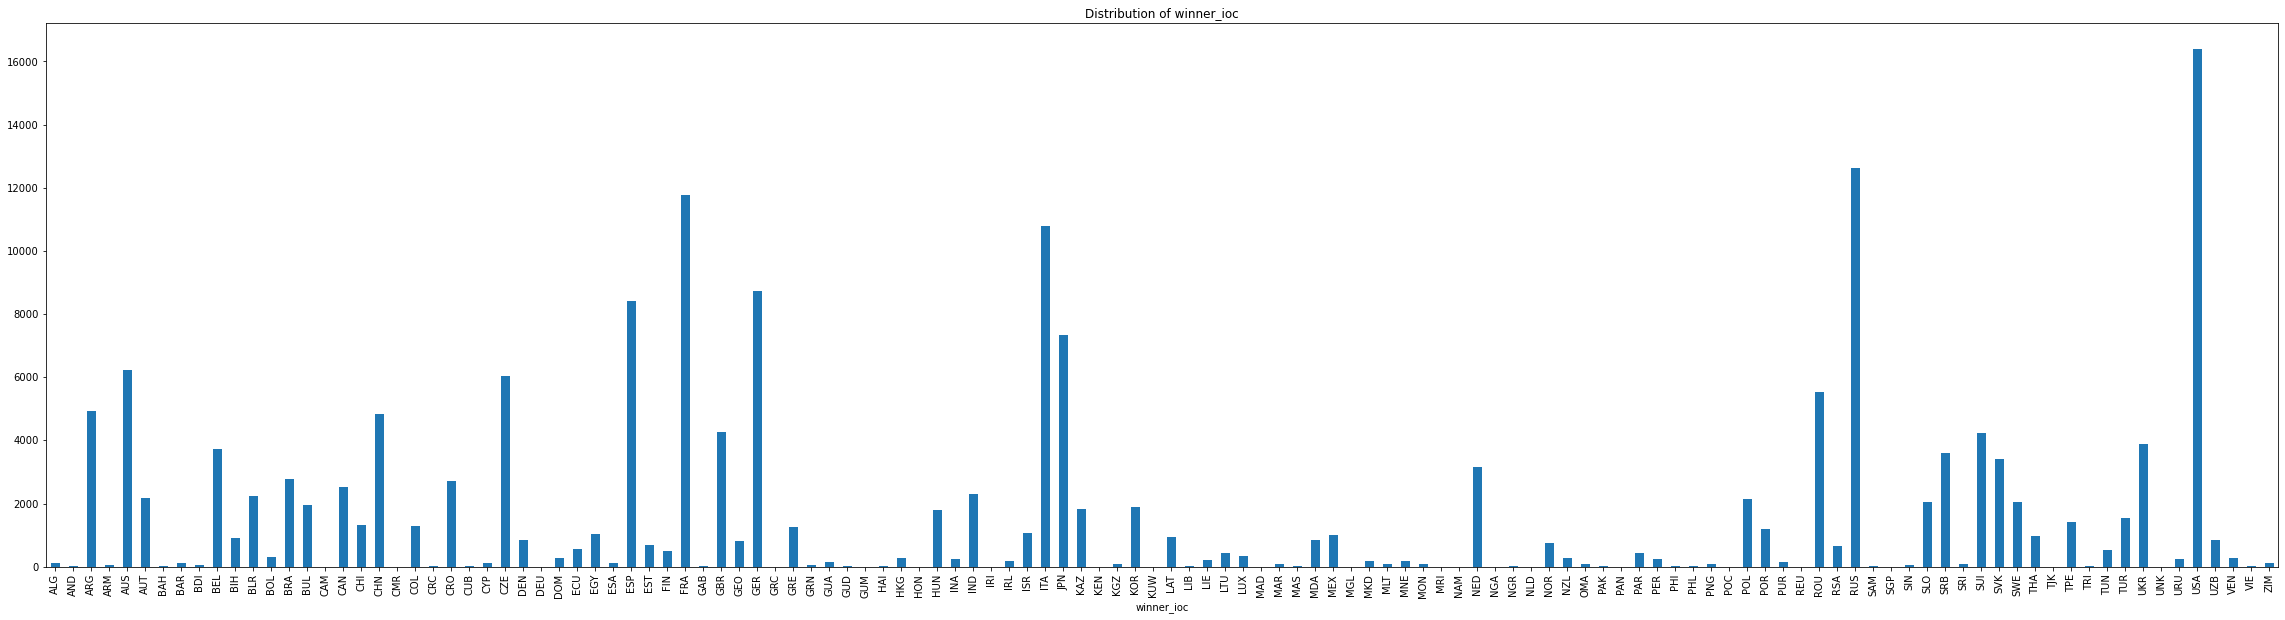

In [35]:
lf = df.groupby([ df.winner_ioc]).size()
lf.plot(
    figsize=(40, 10), 
    title="Distribution of winner_ioc", 
    kind='bar')

<AxesSubplot:title={'center':'Distribution of loser_ioc'}, xlabel='loser_ioc'>

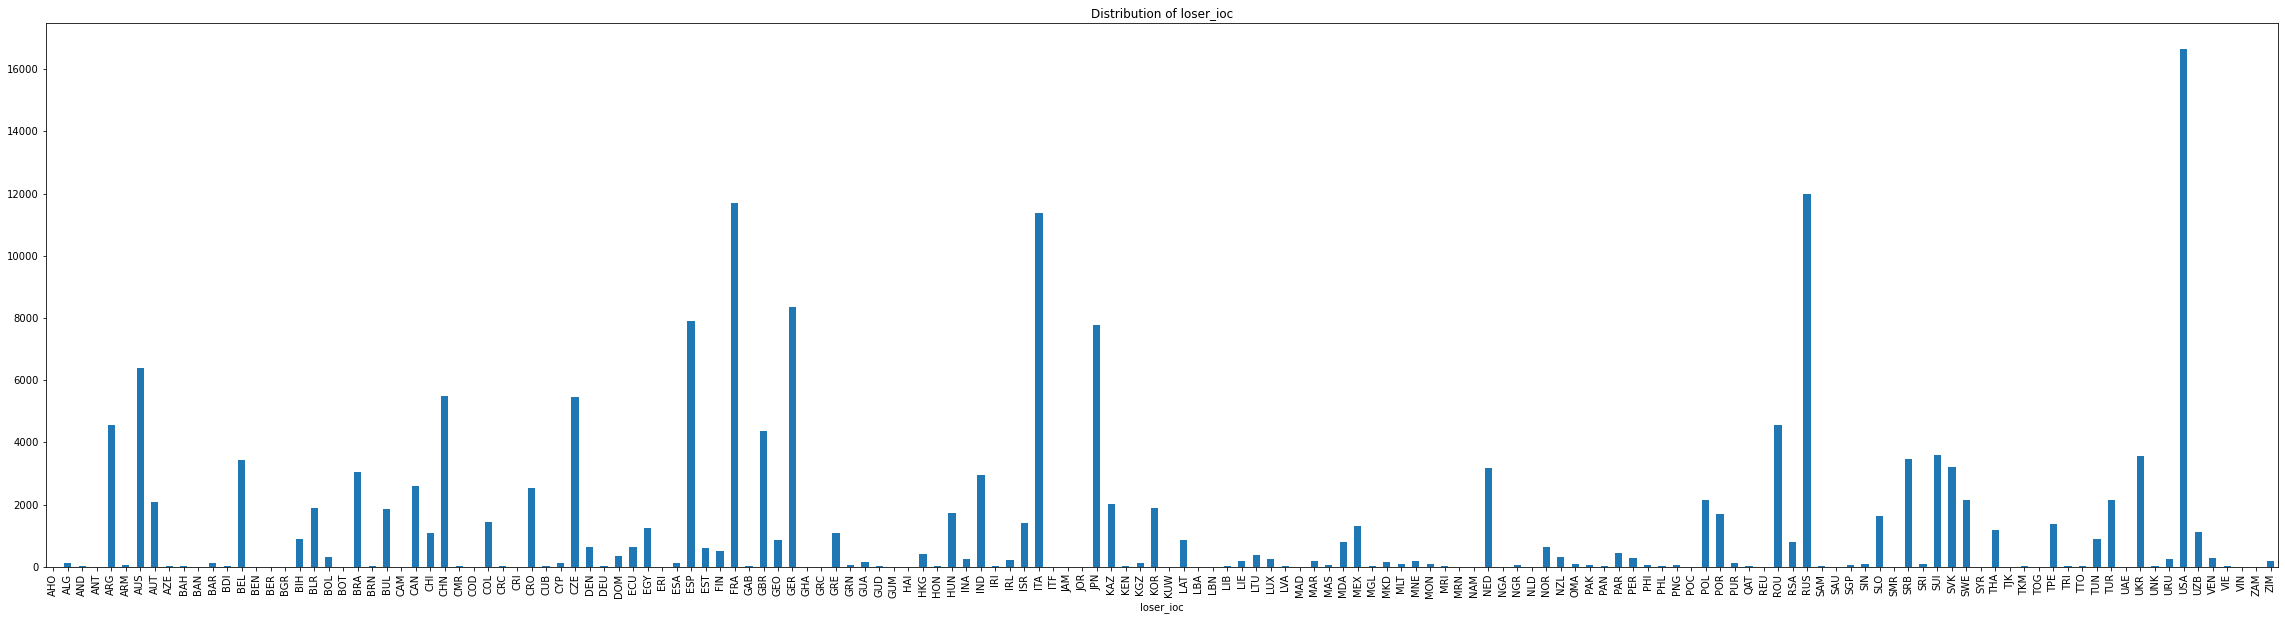

In [36]:
lf = df.groupby([ df.loser_ioc]).size()
lf.plot(
    figsize=(40, 10), 
    title="Distribution of loser_ioc", 
    kind='bar')

### winner hand with loser hand
Distribution of winner and loser hand among matches. Most of the matches have been held between players using the R hand, while those where player with U hand won are against player with also U hand, and matches where player with L hand won are against R hand.

<AxesSubplot:title={'center':'Distribution of the hand used on matches'}, xlabel='winner_hand'>

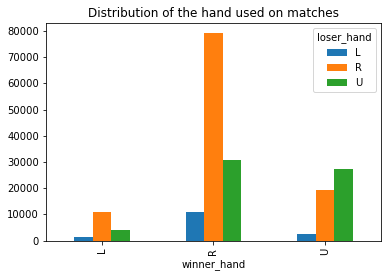

In [37]:
lf = df.groupby([ 'winner_hand', 'loser_hand']).size()
lf = lf.unstack()
lf.plot(
    title="Distribution of the hand used on matches", 
    kind='bar')

### gender with hand
Is shown the distribution between gender and hand of the winner player. Again the R hand is the most predominant one between both the gender. Players with gender U use only R hand. Among the losers the distribution between the hands is quite the same. There is not the same amount of correspondent played matches in particular there is an inversion of L and U in the M loser_gender while in the F loser_gender the amount of played matches with R is less than those of the F winner gender with R of the first graph because increase matches played with U hand.

<AxesSubplot:title={'center':'Distribution of loser_hand with respect to the loser_gender used on matches'}, xlabel='loser_gender'>

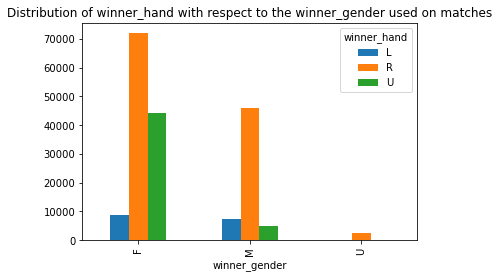

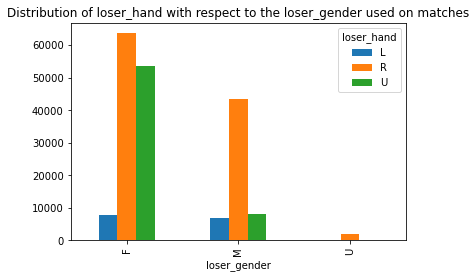

In [38]:
lf = df.groupby([ 'winner_gender', 'winner_hand']).size()
lf = lf.unstack()
lf.plot(
    title="Distribution of winner_hand with respect to the winner_gender used on matches", 
    kind='bar')
lf = df.groupby([ 'loser_gender', 'loser_hand']).size()
lf = lf.unstack()
lf.plot(
    title="Distribution of loser_hand with respect to the loser_gender used on matches", 
    kind='bar')

### gender
The ⅔ of all the dataset represents female tournaments. With reference to the U values there are very few where some are known winners males and some others are known losers males. The correspondent U part may be both F or M, it is supposed that there are not mixed matches so that the correspondent value is implicitly deduced but it could be better if contemporary checked other useful attributes such as the tourney_level, that is for instance dependent on the gender type.
What is sure is that in the female tournaments there are no matches in which only one part is known and the other is not. 


<AxesSubplot:title={'center':'Distribution of genders on matches'}, xlabel='winner_gender'>

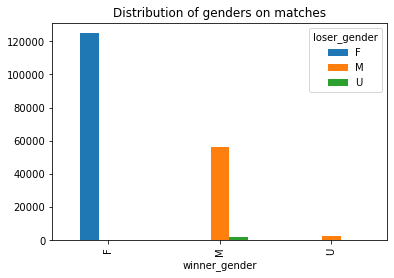

In [39]:
lf = df.groupby([ 'winner_gender', 'loser_gender']).size()
lf = lf.unstack()
lf.plot(
    title="Distribution of genders on matches", 
    kind='bar')

### global view of gender and hand
All combinations between gender and hand are shown. It's possible to see that the most frequent combination is with matches between F genders and R hands followed by U hands and F genders. 

<AxesSubplot:title={'center':'Distribution of the hand used on matches'}, xlabel='winner_hand,loser_hand,winner_gender'>

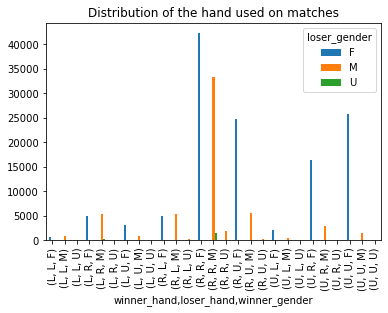

In [40]:
lf = df.groupby(['winner_hand', 'loser_hand', 'winner_gender', 'loser_gender']).size()
lf = lf.unstack()
lf.plot(
    title="Distribution of the hand used on matches", 
    kind='bar')

### winner_entry
By visualizing the distribution of winner_entry/loser_entry, note that some are present only with the losers and vice versa, some are present only with the winners. The predominant entries are 'Q' and 'WC' while the others are few.

<AxesSubplot:title={'center':'Distribution of winner_entry'}, xlabel='winner_entry'>

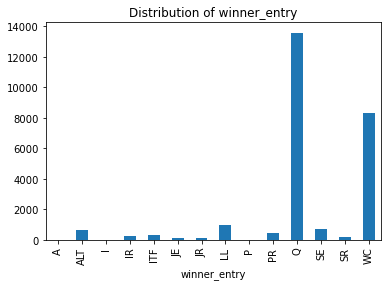

In [41]:
lf = df.groupby([ 'winner_entry']).size()
lf.plot(
    title="Distribution of winner_entry",
    kind='bar')

<AxesSubplot:title={'center':'Distribution of winner_entry'}, xlabel='winner_entry'>

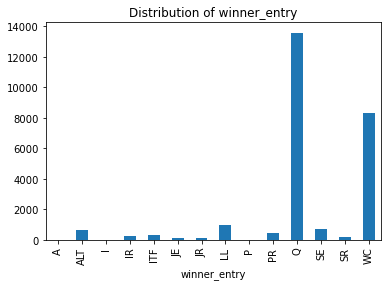

In [42]:
lf = df.groupby([ 'winner_entry']).size()
lf.plot(
    title="Distribution of winner_entry",
    kind='bar')

### rank with rank points
Lower is the rank’s value and so players with best performances, then higher is the rank_points attribute, and vice versa, while higher is the rank’s value and so players with low performances, then lower is the rank_points attribute. The distribution has an iperbole behavior.

Text(0, 0.5, 'loser_rank_points')

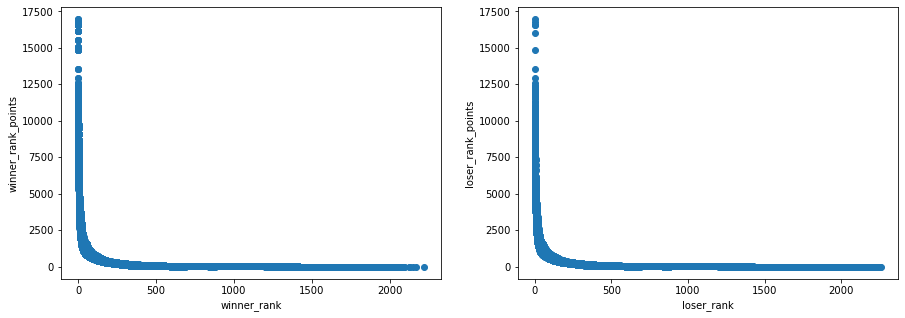

In [43]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
axs[0].scatter(df['winner_rank'],df['winner_rank_points'])
axs[0].set_xlabel('winner_rank')
axs[0].set_ylabel('winner_rank_points')

axs[1].scatter(df['loser_rank'],df['loser_rank_points'])
axs[1].set_xlabel('loser_rank')
axs[1].set_ylabel('loser_rank_points')


# Data Correlation
Compute the correlation matrix related to the numerical attributes of the dataset.To visualize in a better way the correlation between numerical attributes we use heatmap. Cell's colors represent intensity of correlection between two attributes.Some attributes are strongly correleted with a coefficient greater than 0.9 such as attributes reguarding the number services (svpt, 1stIn and 1stWon, SvGms) and draw_size with tourney_spectator. As shown in scatter plots, all attributes with high correlation have a linear trend, together to some more distant points that represent outliers.

In [44]:
def scatter_subplots(cell, x, y, x_label, y_label):
    cell.scatter(x, y)
    cell.set_title('Corr(' + x_label + ',' + y_label +'): ' + str(x.corr(y)))
    cell.set_xlabel(x_label)
    cell.set_ylabel(y_label)

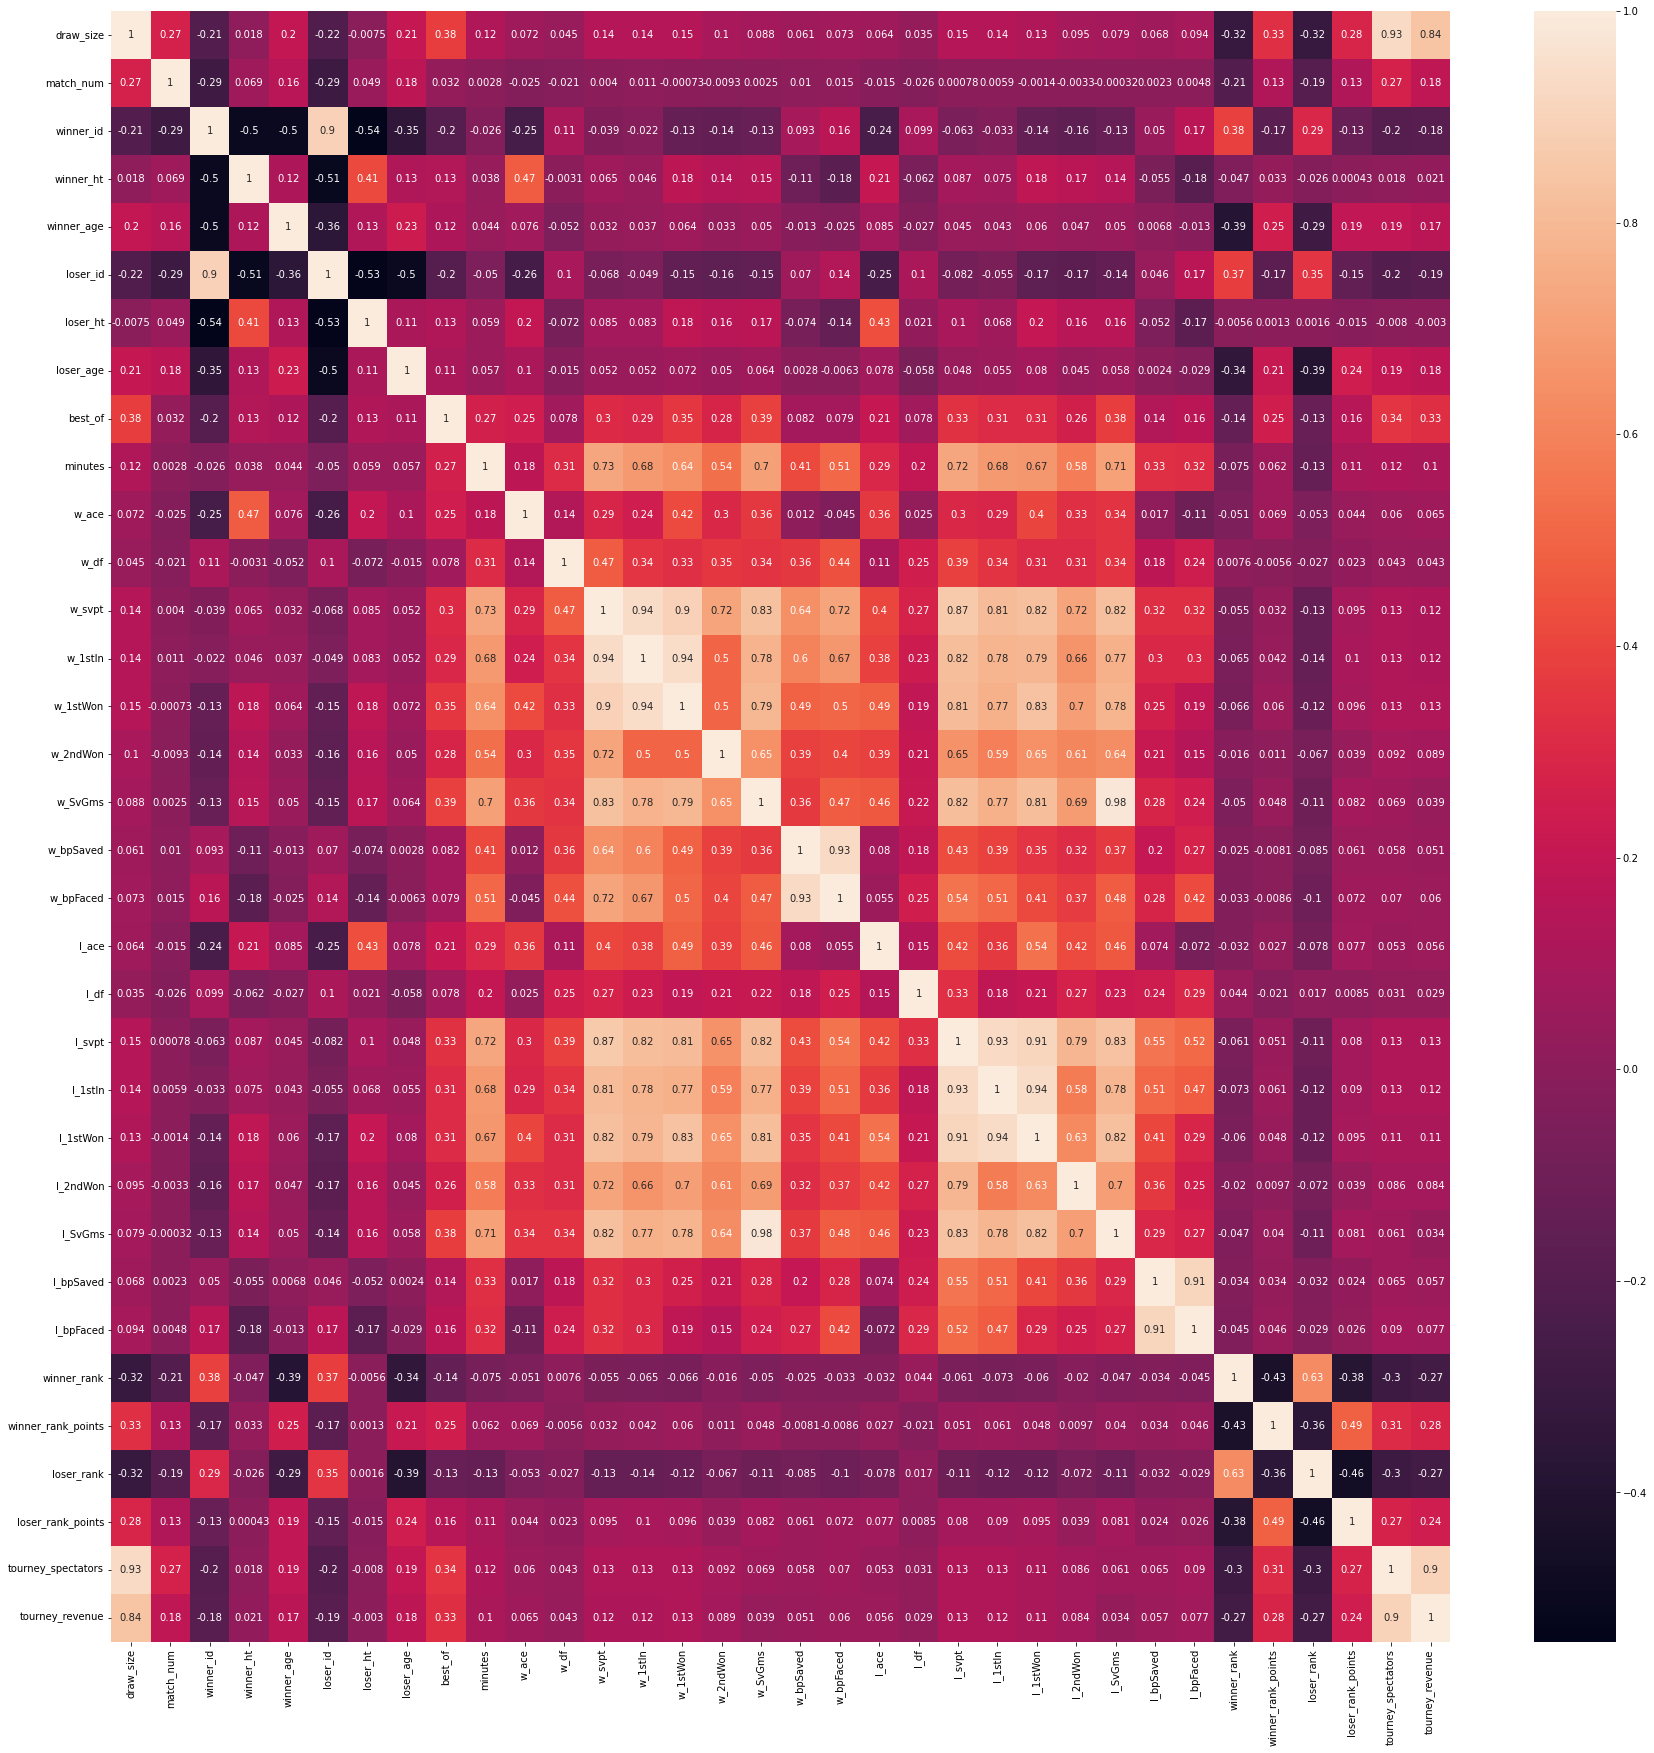

In [45]:
matrix = df.corr()
fig, ax = plt.subplots(figsize=(30, 30))         # Sample figsize in inches
sn.heatmap(matrix, annot=True)
plt.show()

## Correlation between attributes with coefficient >= 90

### Correlation between attributes related to tourney


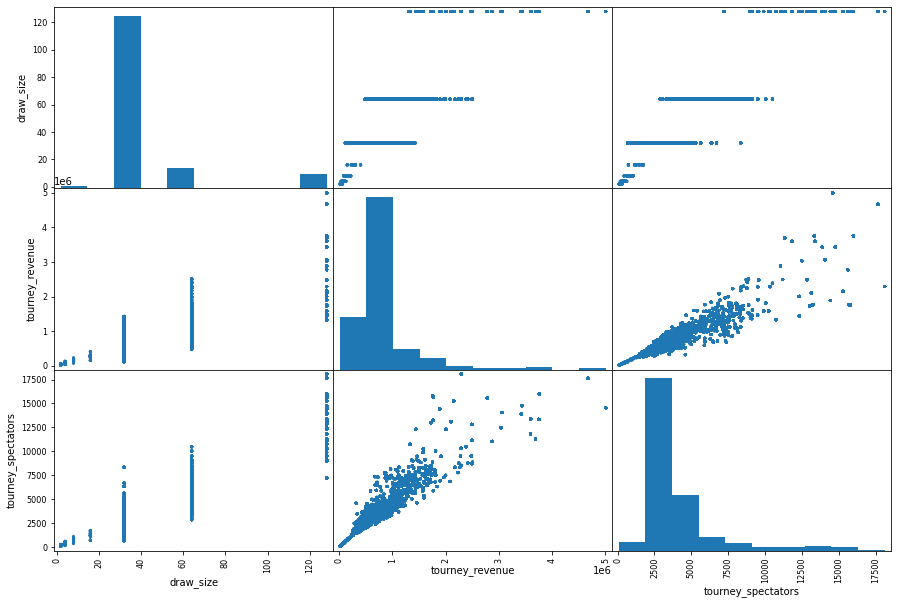

In [46]:
pd.plotting.scatter_matrix(df[['draw_size', 'tourney_revenue', 'tourney_spectators']], figsize = (15, 10))
plt.show()

### Correlation between breakpoints

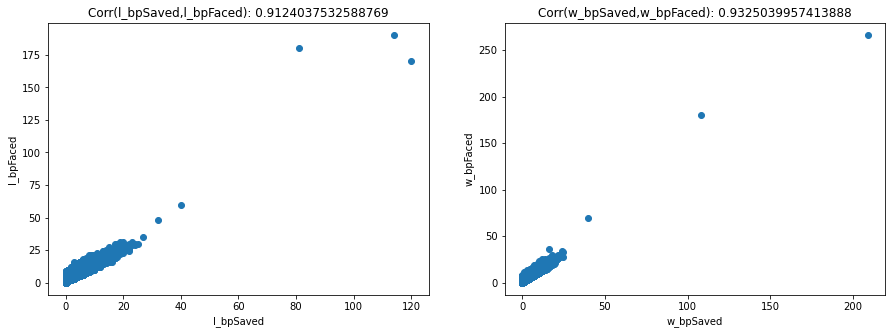

In [47]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))
scatter_subplots(axs[0], df.l_bpSaved, df.l_bpFaced, 'l_bpSaved', 'l_bpFaced')
scatter_subplots(axs[1], df.w_bpSaved, df.w_bpFaced, 'w_bpSaved', 'w_bpFaced')

### Correlation between attributes related to services

Corr( l_svpt, l_1stIn) = 0.9319198242617064 
Corr( l_svpt, l_1stWon) = 0.9106908893989659 
Corr(l_1stIn, l_1stWon) = 0.9359395228832281 
Corr(l_SvGms, l_1stIn) = 0.7840426499908718 
Corr(l_SvGms, l_svpt) = 0.8138969451454271 
Corr(l_SvGms, l_1stWon) = 0.8245728286088528


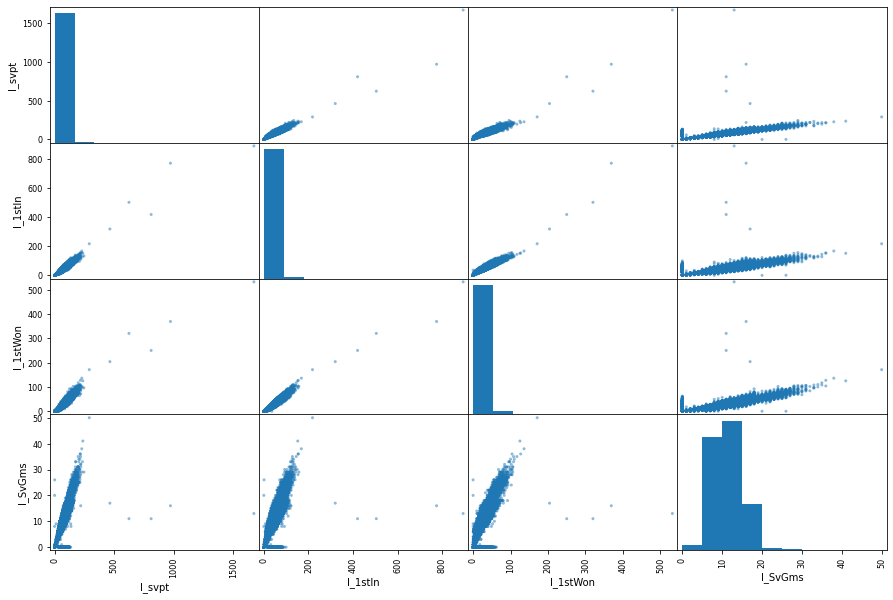

In [48]:
pd.plotting.scatter_matrix(df[['l_svpt', 'l_1stIn', 'l_1stWon', 'l_SvGms']], figsize = (15, 10))
print("Corr( l_svpt, l_1stIn) =", df.l_svpt.corr(df.l_1stIn), "\nCorr( l_svpt, l_1stWon) =", df.l_svpt.corr(df.l_1stWon), "\nCorr(l_1stIn, l_1stWon) =", df.l_1stIn.corr(df.l_1stWon),
     "\nCorr(l_SvGms, l_1stIn) =", df.l_SvGms.corr(df.l_1stIn),  "\nCorr(l_SvGms, l_svpt) =", df.w_SvGms.corr(df.l_1stWon), "\nCorr(l_SvGms, l_1stWon) =", df.l_SvGms.corr(df.l_1stWon),)
plt.show()

Corr( w_svpt, w_1stIn) = 0.9387942855567147 
Corr( w_svpt, w_1stWon) = 0.8958797627131596 
Corr(w_1stIn, w_1stWon) = 0.942874104028165 
Corr(w_SvGms, w_1stIn) = 0.7763928732191767 
Corr(w_SvGms, w_svpt) = 0.7945277700671561 
Corr(w_SvGms, w_1stWon) = 0.7945277700671561


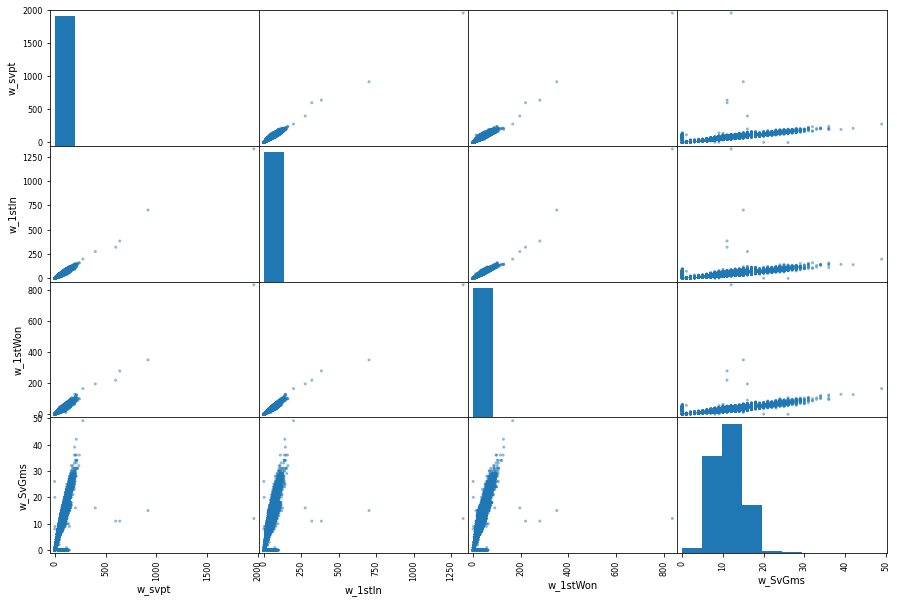

In [49]:
pd.plotting.scatter_matrix(df[['w_svpt', 'w_1stIn', 'w_1stWon', 'w_SvGms']], figsize = (15, 10))
print("Corr( w_svpt, w_1stIn) =", df.w_svpt.corr(df.w_1stIn), "\nCorr( w_svpt, w_1stWon) =", df.w_svpt.corr(df.w_1stWon), "\nCorr(w_1stIn, w_1stWon) =", df.w_1stIn.corr(df.w_1stWon),
     "\nCorr(w_SvGms, w_1stIn) =", df.w_SvGms.corr(df.w_1stIn),  "\nCorr(w_SvGms, w_svpt) =", df.w_SvGms.corr(df.w_1stWon), "\nCorr(w_SvGms, w_1stWon) =", df.w_SvGms.corr(df.w_1stWon))
plt.show()

## Correlation between attributes with coefficient >= 70

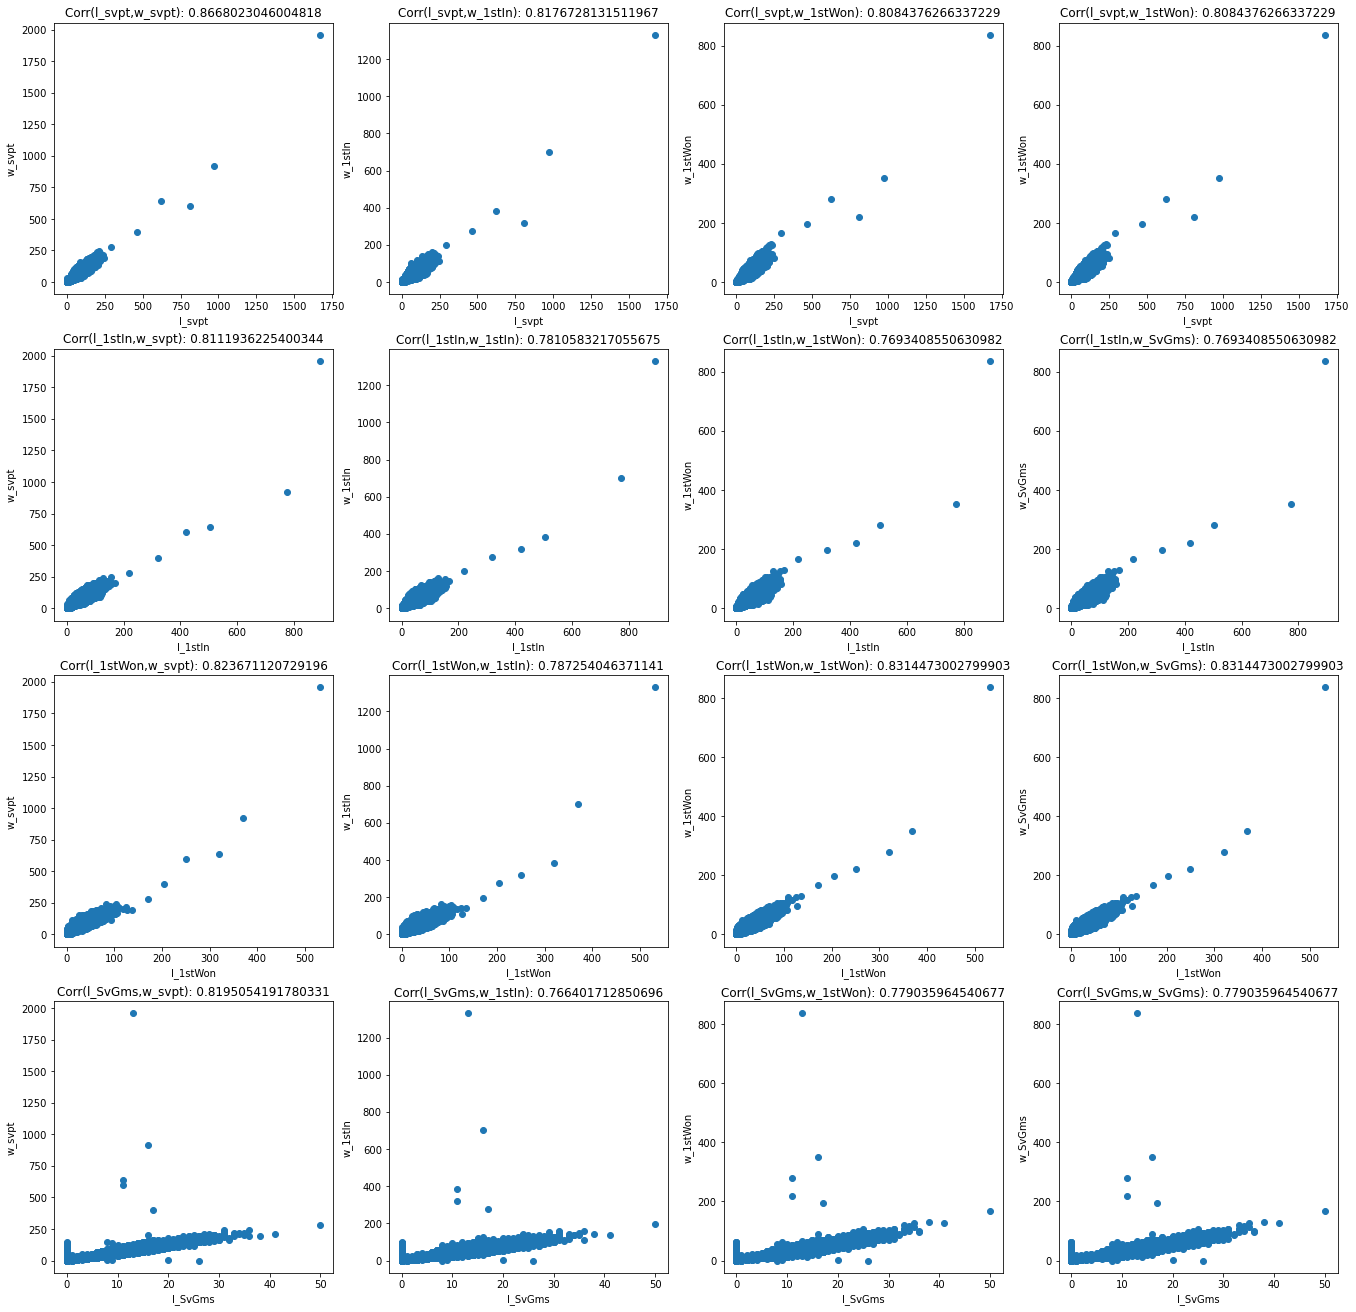

In [50]:
f, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(23,23))
scatter_subplots(axs[0][0], df.l_svpt, df.w_svpt, 'l_svpt', 'w_svpt')
scatter_subplots(axs[0][1], df.l_svpt, df.w_1stIn, 'l_svpt', 'w_1stIn')
scatter_subplots(axs[0][2], df.l_svpt, df.w_1stWon, 'l_svpt', 'w_1stWon')
scatter_subplots(axs[0][3], df.l_svpt, df.w_1stWon, 'l_svpt', 'w_1stWon')

scatter_subplots(axs[1][0], df.l_1stIn, df.w_svpt, 'l_1stIn', 'w_svpt')
scatter_subplots(axs[1][1], df.l_1stIn, df.w_1stIn, 'l_1stIn', 'w_1stIn')
scatter_subplots(axs[1][2], df.l_1stIn, df.w_1stWon, 'l_1stIn', 'w_1stWon')
scatter_subplots(axs[1][3], df.l_1stIn, df.w_1stWon, 'l_1stIn', 'w_SvGms')


scatter_subplots(axs[2][0], df.l_1stWon, df.w_svpt, 'l_1stWon', 'w_svpt')
scatter_subplots(axs[2][1], df.l_1stWon, df.w_1stIn, 'l_1stWon', 'w_1stIn')
scatter_subplots(axs[2][2], df.l_1stWon, df.w_1stWon, 'l_1stWon', 'w_1stWon')
scatter_subplots(axs[2][3], df.l_1stWon, df.w_1stWon, 'l_1stWon', 'w_SvGms')

scatter_subplots(axs[3][0], df.l_SvGms, df.w_svpt, 'l_SvGms', 'w_svpt')
scatter_subplots(axs[3][1], df.l_SvGms, df.w_1stIn, 'l_SvGms', 'w_1stIn')
scatter_subplots(axs[3][2], df.l_SvGms, df.w_1stWon, 'l_SvGms', 'w_1stWon')
scatter_subplots(axs[3][3], df.l_SvGms, df.w_1stWon, 'l_SvGms', 'w_SvGms')

plt.show()

# Export into CSV files

In [51]:
df.to_csv('dataset/matches_understanding.csv')